# Effects of Chaining rNMF and sICA

This Notebook reproduces some results of the manuscript http://dx.doi.org/10.1016/j.neuroimage.2014.04.041. Please make sure to have the regNMF module (available at https://github.com/jansoe/FUImaging) in your PYTHONPATH.

In [1]:
import sys
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from scipy.spatial.distance import pdist
from scipy.stats import gaussian_kde

pythonpath_for_regnmf = os.path.realpath(os.path.join(os.path.pardir, os.path.pardir))
sys.path.append(pythonpath_for_regnmf)      
from regnmf import ImageAnalysisComponents as ia
from regnmf import datamaker
from regnmf.regularizedHALS import convex_cone

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
%matplotlib inline

### Parameter for creation of surrogate Data

In [3]:
param = {'act_time': [0.01, 0.1, 0.3, 0.8, 1.0, 1.0],
 'cov': 0.3,
 'latents': 40,
 'mean': 0.2,
 'no_samples': 50,
 'noisevar': 0.2,
 'shape': (50, 50),
 'width':0.1,
 'var': 0.08}

### Parameter for Matrix Factorization

In [4]:
anal_param = {'sparse_param': 0.5,
              'factors': 80,
              'smooth_param': 2,
              'init':'convex', 
              'sparse_fct':'global_sparse',
              'verbose':0
              }

### Helper Functions

In [5]:
def violin_plot(ax, data, color='b'):
    '''
    create violin plots on an axis
    '''
    w = 0.4
    for p, d in enumerate(data):
        k = gaussian_kde(d) #calculates the kernel density
        m = k.dataset.min() #lower bound of violin
        M = k.dataset.max() #upper bound of violin
        x = np.arange(m,M,(M-m)/100.) # support for violin
        v = k.evaluate(x) #violin profile (density curve)
        scale = w/v.max()
        v = v*scale #scaling the violin to the available space
        ax.fill_betweenx(x,p,v+p, facecolor=color, edgecolor = color, alpha=1)
        ax.fill_betweenx(x,p,-v+p, facecolor=color, edgecolor = color, alpha=1)
        
        #median
        perc = np.percentile(d, [25,50,75])
        perc_width = k.evaluate(perc)*scale 
        l1, = ax.plot([p-perc_width[1],p+perc_width[1]],[perc[1], perc[1]], 'k', lw=0.5)
        l2, = ax.plot([p-perc_width[0],p+perc_width[0]],[perc[0], perc[0]], '0.25', lw=0.5)
        ax.plot([p-perc_width[2],p+perc_width[2]],[perc[2], perc[2]], '0.25', lw=0.5)
    ax.legend([l1, l2], ['median', 'quartiles'], prop={'size':fontsize}, numpoints=1, 
              loc = 'lower right', labelspacing=0.1, handletextpad=0.5, bbox_to_anchor = (1, 0.9), 
              handlelength=1, borderaxespad=-0.5, frameon=False)
    
def cor(time1, time2, num_sources):
    '''calculate crosscorrelation between sources and latents'''
    return np.corrcoef(np.vstack((time1, time2)))[num_sources:, :num_sources]

## Perform chained matrix factorization

applied factorizations:

- plain rNMF and plain sICA
- rNMF on data from sICA (i.e. PCA) reconstruction, that is __A*X__
- rNMF initialized by rectified sICA components
- sICA on pixel participation of rNMF
- sICA on data from rNMF reconstruction

In [6]:
num_datasets = 5 #number of independent datasets

mse = defaultdict(list)
cor = defaultdict(list)

for dummy in range(num_datasets):
    compare = {}
    # create data
    tempdata = datamaker.Dataset(param)
    
    # plain NMF
    nnma = ia.NNMF(maxcount=50, num_components=anal_param['factors'])
    anal_param.update({'init':'convex'})
    nnma.param.update(anal_param)  
    
    compare['nmf'] = nnma(ia.TimeSeries(tempdata.observed, shape=param['shape']))
    
    # plain sICA
    sica = ia.sICA(num_components=anal_param['factors'])
    compare['sica'] = sica(ia.TimeSeries(tempdata.observed, shape=param['shape']))
    
    # NMF on sICA reduced data
    reduced_data = np.dot(compare['sica']._series, compare['sica'].base._series)
    compare['sicareduced_nmf'] = nnma(ia.TimeSeries(reduced_data, shape=param['shape']))
    
    # sICA initialized NMF
    nnma = ia.NNMF(maxcount=50, num_components=anal_param['factors'])
    A = compare['sica']._series.copy()
    X = compare['sica'].base._series.copy()
    A[A<0]=0
    X[X<0]=0
    anal_param.update({'init':{'A':A, 'X':X}})
    nnma.param.update(anal_param)    
    compare['sicainit_nmf'] = nnma(ia.TimeSeries(tempdata.observed, shape=param['shape']))
    
    # NMF initialized sICA
    compare['nmfinit_sica'] = compare['nmf'].copy()
    sica = ia.sICA(num_components=anal_param['factors'])
    out_temp = sica(compare['nmfinit_sica'].base.copy())
    compare['nmfinit_sica'].base = out_temp.base
    compare['nmfinit_sica']._series = np.dot(compare['nmfinit_sica']._series, out_temp._series)
    
    # sICA on NMF reduced data
    nmf_reduced = np.dot(compare['nmf']._series, compare['nmf'].base._series)
    sica = ia.sICA(num_components=anal_param['factors'])
    compare['nmfreduced_sica'] = sica(ia.TimeSeries(nmf_reduced, shape=param['shape']))
    
    # sICA on convex cone
    compare['ccinit_sica'] = compare['nmf'].copy()
    init = convex_cone(tempdata.observed, anal_param['factors'])
    out_temp = sica(ia.TimeSeries(np.array(init['base']), shape=param['shape']))
    compare['ccinit_sica'].base = out_temp.base
    compare['ccinit_sica']._series = np.dot(np.array(init['timecourses']).T, out_temp._series)
    
    #collect performance measures
    for k in compare:
        cor[k] += list(tempdata.cor2source(compare[k])[1])
        mse[k] += list(tempdata.mse2source(compare[k], local=0.05))

/home/sam/anaconda3/envs/glomcentric_code/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/home/sam/anaconda3/envs/glomcentric_code/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/home/sam/anaconda3/envs/glomcentric_code/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/sam/anaconda3/envs/glomcentric_code/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/sam/anaconda3/envs/glomcentric_code/lib/python3.8/site

### Violinplots of Source Recovery (SR)

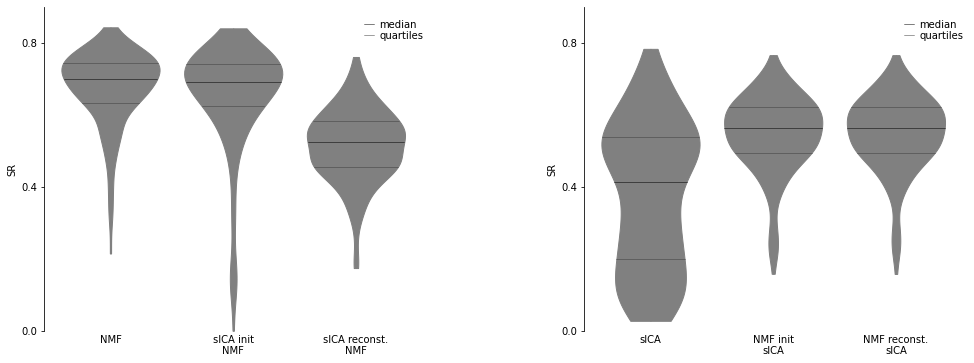

In [7]:
fig = plt.figure(figsize=(15, 6))
fontsize = 10

ax = fig.add_axes([0.1,0.2,0.35,0.75])
keys = ['nmf', 'sicainit_nmf', 'sicareduced_nmf']
data = [1-np.array(mse[i]) for i in keys]
violin_plot(ax, data, '0.5')
ax.set_xticks(range(len(keys)))
ax.set_xticklabels(['NMF', 'sICA init\nNMF', 'sICA reconst.\nNMF'],
                   rotation='0', ha='center', size=fontsize)
ax.set_ylabel('SR', size=fontsize)
ax.set_ylim([0,0.9])
ax.set_yticks([0,0.4,0.8])
ax.yaxis.set_tick_params(labelsize=fontsize)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_tick_params(size=0)
for pos in ['right', 'bottom', 'top']:
    ax.spines[pos].set_color('none')

    
ax = fig.add_axes([0.6,0.2,0.35,0.75])
keys = ['sica', 'nmfinit_sica', 'nmfreduced_sica']
data = [1-np.array(mse[i]) for i in keys]
violin_plot(ax, data, '0.5')
ax.set_xticks(range(len(keys)))
ax.set_xticklabels(['sICA', 'NMF init\nsICA', 'NMF reconst.\nsICA'],
                   rotation='0', ha='center', size=fontsize)
ax.set_ylabel('SR', size=fontsize)
ax.set_ylim([0,0.9])
ax.set_yticks([0,0.4,0.8])
ax.yaxis.set_tick_params(labelsize=fontsize)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_tick_params(size=0)
for pos in ['right', 'bottom', 'top']:
    ax.spines[pos].set_color('none')

plt.show()